# Custom Ensemble Models

In [3]:
import random
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, roc_curve, precision_score, recall_score, confusion_matrix, auc
from imblearn.over_sampling import RandomOverSampler, SMOTE
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from joblib import dump, load
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import lightgbm
from sklearn.ensemble import RandomForestClassifier

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 1. Train-Test Split(80:20)

In [4]:
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Self_Case_study/train_final20.csv")
X =  df.drop(['PotentialFraud'], axis=1)
Y = df['PotentialFraud'].values
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, stratify=Y, random_state=42)
print("Shape of train data: ", X_train.shape)
print("Shape of test data: ", X_test.shape)

Shape of train data:  (4328, 20)
Shape of test data:  (1082, 20)


In [5]:
# Scaling data
s = StandardScaler()
X_train = s.fit_transform(X_train)
X_test = s.transform(X_test)

# 2. Splitting train data(50:50)

In [6]:
D1_50, D2_50, y1_50, y2_50 = train_test_split(X_train, y_train, test_size=0.5, stratify=y_train, random_state=42)
print("Shape of train data: ", D1_50.shape)
print("Shape of test data: ", D2_50.shape)

Shape of train data:  (2164, 20)
Shape of test data:  (2164, 20)


# 3. Creating k models

In [7]:
def get_kmodels(x, y, k, size):
    '''This function generates creates k random samples from data
       and then fits k different models on them'''
    models = []
    for i in range(k):
        indices = np.random.choice(len(x), size, replace=True)
        xi, yi = x[indices], y[indices]
        model = LogisticRegression(C=0.23357214690901212, class_weight='balanced',
                                   max_iter=1000).fit(xi, yi)
        models.append(model)
    return models

# 4. Stacked Classifiers on metadata with k predictions

In [8]:
def generate_data(x, models):
    '''This function generates metadata with k predictions of k models'''
    res_x = []
    for model in models:
        res_x.append(model.predict(x))
    res_x = np.array(res_x).T
    
    return res_x

## 4.1 lightgbm as Stack Classifier

In [ ]:
# Hypertuning 'k' using lightgbm as as Stack Classifier

scores = []
lightgbm_models = []

for k in [20, 50, 100, 200, 500]:
    #Generating models
    models = get_kmodels(D1_50, y1_50, k, 1200)
    # Generating meta-data
    x_meta = generate_data(D2_50, models)
    y_meta = y2_50

    clf = GridSearchCV(lightgbm.LGBMClassifier(class_weight='balanced'),
                       param_grid = {'learning_rate': [0.001, 0.002, 0.005, 0.1, 0.3, 0.5, 0.7],
                                     'n_estimators': [50, 100, 200, 300, 500]},
                       scoring='recall', verbose=1,
                       n_jobs=-1, cv=3)

    clf.fit(x_meta, y_meta)
    scores.append(clf.best_score_)
    lightgbm_models.append(clf.best_estimator_)
    

print()
print("Results for lightgbm model")
print("k: ", [20, 50, 100, 200, 500])
print(" recall score: ", scores)
print()
print(lightgbm_models[np.argmax(scores)])

Fitting 3 folds for each of 35 candidates, totalling 105 fits
Fitting 3 folds for each of 35 candidates, totalling 105 fits
Fitting 3 folds for each of 35 candidates, totalling 105 fits
Fitting 3 folds for each of 35 candidates, totalling 105 fits
Fitting 3 folds for each of 35 candidates, totalling 105 fits

Results for lightgbm model
k:  [20, 50, 100, 200, 500]
 recall score:  [0.7672666081357916, 0.7673397717295872, 0.7823383084577115, 0.7770705297044191, 0.7622914837576822]

LGBMClassifier(class_weight='balanced', learning_rate=0.002, n_estimators=500)


## Observations:
<ul>
    <li> Best recall score of 0.7823 for lighgbm as stack classifier was obtained for k = 100 </li>
</ul>

## 4.2 RandomForest as Stack Classifier

In [ ]:
# Hypertuning 'k' using RandomForest as as Stack Classifier

scores = []
forest_models = []

for k in [20, 50, 100, 200, 500]:
    # Generating models
    models = get_kmodels(D1_50, y1_50, 500, 1200)
    # Generating meta-data
    x_meta = generate_data(D2_50, models)
    y_meta = y2_50

    clf = GridSearchCV(RandomForestClassifier(class_weight='balanced'),
                       param_grid = {'n_estimators': [50, 100, 200, 300, 500, 1000],
                                     'max_depth': [5, 10, 50, None],
                                     'max_features': ['auto', 'sqrt', 'log2']},
                       scoring='recall', verbose=1,
                       n_jobs=-1, cv=3)


    clf.fit(x_meta, y_meta)
    scores.append(clf.best_score_)
    forest_models.append(clf.best_estimator_)
    

print()
print("Results for RandomForest model")
print("k: ", [20, 50, 100, 200, 500])
print("recall score: ", scores)
print()
best_forest = forest_models[np.argmax(scores)]
print(best_forest)

Fitting 3 folds for each of 72 candidates, totalling 216 fits
Fitting 3 folds for each of 72 candidates, totalling 216 fits
Fitting 3 folds for each of 72 candidates, totalling 216 fits
Fitting 3 folds for each of 72 candidates, totalling 216 fits
Fitting 3 folds for each of 72 candidates, totalling 216 fits

Results for RandomForest model
k:  [20, 50, 100, 200, 500]
recall score:  [0.7128328943517706, 0.7128328943517706, 0.7029558091893474, 0.7128328943517706, 0.7128328943517706]

RandomForestClassifier(class_weight='balanced', max_depth=5)


## Observations:
<ul>
    <li> Best recall score of 0.7128 for RandomForest as stack classifier was obtained for k = 20 </li>
    <li> RandomForest Classifier performed lesser than lightgbm. </li>
</ul>

## 4.3 SVM as Stack Classifier

In [ ]:
# Hypertuning 'k' using SVM as as Stack Classifier

scores = []
svm_models = []

for k in [20, 50, 100, 200, 500]:
    # Generating models
    models = get_kmodels(D1_50, y1_50, 500, 1200)
    # Generating meta-data
    x_meta = generate_data(D2_50, models)
    y_meta = y2_50

    c_range = np.logspace(-3, 2, 5)
    gamma = np.logspace(-2, 3, 15)

    clf = GridSearchCV(SVC(class_weight='balanced', probability=True),
                       param_grid = {'C':c_range, 'gamma':gamma},
                       scoring='recall', verbose=1,
                       n_jobs=-1, cv=3)


    clf.fit(x_meta, y_meta)
    scores.append(clf.best_score_)
    svm_models.append(clf.best_estimator_)
    

print()
print("Results for SVM model")
print("k: ", [20, 50, 100, 200, 500])
print("recall score: ", scores)
print()
best_svm = svm_models[np.argmax(
    scores)]
print(best_svm)

Fitting 3 folds for each of 75 candidates, totalling 225 fits
Fitting 3 folds for each of 75 candidates, totalling 225 fits
Fitting 3 folds for each of 75 candidates, totalling 225 fits
Fitting 3 folds for each of 75 candidates, totalling 225 fits
Fitting 3 folds for each of 75 candidates, totalling 225 fits

Results for SVM model
k:  [20, 50, 100, 200, 500]
recall score:  [0.8516242317822651, 0.8516242317822651, 0.8516242317822651, 0.8615013169446883, 0.8516242317822651]

SVC(C=0.01778279410038923, class_weight='balanced', gamma=1.3894954943731375,
    probability=True)


## Observations:
<ul>
    <li> Best recall score of 0.8615 for SVM as stack classifier was obtained for k = 200 </li>
    <li> SVM model gave the best results as a Stack Classifier. </li>
</ul>

# 5. Best SVM stack classifier

In [ ]:
# Generating models
models = get_kmodels(D1_50, y1_50, 200, 1200)

# Generating meta-data
x_meta = generate_data(D2_50, models)
y_meta = y2_50

best_svm.fit(x_meta, y_meta)

SVC(C=0.01778279410038923, class_weight='balanced', gamma=1.3894954943731375,
    probability=True)

In [ ]:
# Saving all base models
for i in range(len(models)):
    dump(models[i], '/content/drive/MyDrive/Colab Notebooks/Self_Case_study/1st case study/BaseModel'+str(i)+'.joblib')
print("Saved all models!")

Saved all models!


In [ ]:
# Saving model
dump(best_svm, '/content/drive/MyDrive/Colab Notebooks/Self_Case_study/1st case study/best_custom_model.joblib')
print("Model Saved successfully!")

Model Saved successfully!


# 6. Evaluation Metrics

In [9]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    #divide each element of the confusion matrix with the sum of elements in that column
    
    # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis = 1)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]

    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1
    
    B =(C/C.sum(axis=0))
    #divid each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 
    plt.figure(figsize=(20,4))
    
    labels = [0,1]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

# 7. Predictions on test data with custom model

In [14]:
# Loading base learners
files = os.listdir('/content/drive/MyDrive/Colab Notebooks/Self_Case_study/1st case study/BaseModel')

print(files)

['BaseModel134.joblib', 'BaseModel13.joblib', 'BaseModel130.joblib', 'BaseModel132.joblib', 'BaseModel128.joblib', 'BaseModel131.joblib', 'BaseModel133.joblib', 'BaseModel129.joblib', 'BaseModel126.joblib', 'BaseModel127.joblib', 'BaseModel125.joblib', 'BaseModel120.joblib', 'BaseModel121.joblib', 'BaseModel122.joblib', 'BaseModel118.joblib', 'BaseModel12.joblib', 'BaseModel117.joblib', 'BaseModel119.joblib', 'BaseModel124.joblib', 'BaseModel123.joblib', 'BaseModel116.joblib', 'BaseModel115.joblib', 'BaseModel113.joblib', 'BaseModel108.joblib', 'BaseModel112.joblib', 'BaseModel109.joblib', 'BaseModel110.joblib', 'BaseModel111.joblib', 'BaseModel11.joblib', 'BaseModel114.joblib', 'BaseModel107.joblib', 'BaseModel106.joblib', 'BaseModel105.joblib', 'BaseModel102.joblib', 'BaseModel101.joblib', 'BaseModel103.joblib', 'BaseModel100.joblib', 'BaseModel1.joblib', 'BaseModel10.joblib', 'BaseModel104.joblib', 'BaseModel0.joblib', 'BaseModel136.joblib', 'BaseModel135.joblib', 'BaseModel184.jobl

In [16]:
models = []
for model in files:
    clf = load('/content/drive/MyDrive/Colab Notebooks/Self_Case_study/1st case study/BaseModel/'+model)
    models.append(clf)

In [18]:
# Loading custom model
stacked_clf = load('/content/drive/MyDrive/Colab Notebooks/Self_Case_study/1st case study/best_custom_model.joblib')
stacked_clf

SVC(C=0.01778279410038923, class_weight='balanced', gamma=1.3894954943731375,
    probability=True)

In [19]:
# Generating models
models = get_kmodels(D1_50, y1_50, 200, 1200)

# Generating meta-data
x_meta = generate_data(D2_50, models)
y_meta = y2_50

In [20]:
x_meta = generate_data(X_test, models)

In [21]:
y_test_pred = stacked_clf.predict(x_meta)
y_test_prob = stacked_clf.predict_proba(x_meta)

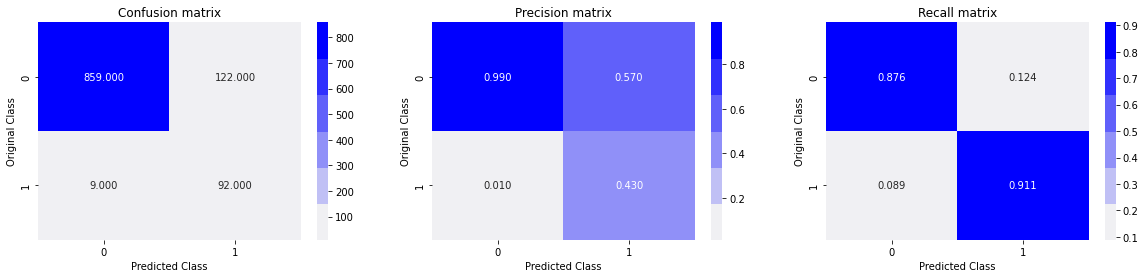

F1 score for test data:  0.5841269841269842
Recall for test data:  0.9108910891089109
Precision for test data:  0.42990654205607476


In [22]:
plot_confusion_matrix(y_test, y_test_pred)
print("F1 score for test data: ", f1_score(y_test, y_test_pred))
print("Recall for test data: ", recall_score(y_test, y_test_pred))
print("Precision for test data: ", precision_score(y_test, y_test_pred))

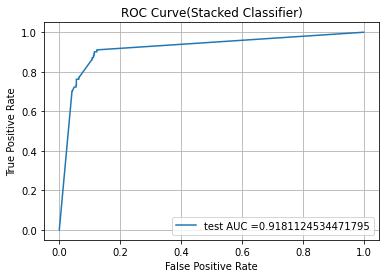

In [23]:
# AUC Score
test_fpr_tfidf, test_tpr_tfidf, te_thresholds_tfidf = roc_curve(y_test, y_test_prob[:, 1])

plt.plot(test_fpr_tfidf, test_tpr_tfidf, label="test AUC ="+str(auc(test_fpr_tfidf, test_tpr_tfidf)))
plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve(Stacked Classifier)")
plt.grid()
plt.show()

# 9. Custom Model vs Logistic Regression

In [25]:
from prettytable import PrettyTable
tb = PrettyTable()
tb.field_names= ("Model Name", "False Negatives", "False Positives", "Recall", "F1")
tb.add_row(["Logistic Regression", 24, 133, 0.84, 0.61])
tb.add_row(["Custom Ensemble LR+SVM", 9, 122, 0.91, 0.585])
print(tb)

+------------------------+-----------------+-----------------+--------+-------+
|       Model Name       | False Negatives | False Positives | Recall |   F1  |
+------------------------+-----------------+-----------------+--------+-------+
|  Logistic Regression   |        24       |       133       |  0.84  |  0.61 |
| Custom Ensemble LR+SVM |        9        |       122       |  0.91  | 0.585 |
+------------------------+-----------------+-----------------+--------+-------+


## Observations:
<ul>
    <li> The no. of false negatives in CustomSVM ensemble model is significantly lesser than Logistic Regression 
    <li> Since, the cost of mis-classiffication of false negative is high for our problem, the best model is custom model which has a better Recall score. </li>
</ul>